# Predicting the Success of a Kickstarter Campaign
Part 1. Initial screening of an assortment of ML models.

In [1]:
-

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
# df = pd.read_pickle('data/kickstarter_data_ds2.pkl')
df = pd.read_sql_query('''SELECT * FROM kickstarter_data_ds2''',engine)
df['idx'] = df['id']
df = df.set_index('idx')
df = df.drop(['index'],1)
print(df.shape)
pd.read_sql_query('''SELECT state, category_main, category_name, backers_count, pct_goal_achieved, usd_pledged, usd_goal, country, currency, campaign_length, staff_pick, blurb_length, launched FROM kickstarter_data_ds2 LIMIT 5''',engine)

(163425, 19)


,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,staff_pick,blurb_length,launched
0,1,fashion,Fashion,30,1.0,1555.0,1500.0,US,USD,31,0,25,2011-12-01
1,0,art,Painting,1,0.0,120.0,3456.0,US,USD,46,0,24,2011-11-16
2,1,film_and_video,Shorts,43,1.5,1831.0,1200.0,US,USD,25,0,18,2011-12-07
3,1,film_and_video,Shorts,6,1.0,1010.0,1000.0,US,USD,30,0,25,2011-12-02
4,1,film_and_video,Shorts,20,1.1,1580.0,1500.0,US,USD,27,0,24,2011-12-05


In [6]:
start_date = datetime.datetime.strptime('2016-01-01', "%Y-%m-%d").date()

df = df[df['launched'] >= start_date] # filter from start date to current
df = df[['state','category_main','category_name','backers_count','usd_goal','country','currency','campaign_length',
        'staff_pick','blurb_length']]
df = df.dropna()

df.shape

(38401, 10)

In [7]:
df.columns

Index(['state', 'category_main', 'category_name', 'backers_count', 'usd_goal',
       'country', 'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object')

In [8]:
df_dummies = pd.get_dummies(df[['category_main','category_name', 'country','currency']],drop_first=True)
df = df_dummies.merge(df,how='inner',left_index=True, right_index=True)
print(df.shape)
print(df.columns)
df.info()

(38401, 197)
Index(['category_main_comics', 'category_main_crafts', 'category_main_dance',
       'category_main_design', 'category_main_fashion',
       'category_main_film_and_video', 'category_main_food',
       'category_main_games', 'category_main_journalism',
       'category_main_music',
       ...
       'state', 'category_main', 'category_name', 'backers_count', 'usd_goal',
       'country', 'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object', length=197)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38401 entries, 1396766240 to 1094069811
Columns: 197 entries, category_main_comics to blurb_length
dtypes: float64(1), int64(5), object(4), uint8(187)
memory usage: 11.3+ MB


In [9]:
# removing all variables that cannot be known before a campaign is launched, such as # backers and $ pledged
df = df.dropna()
X = df.drop(['state','category_main','category_name', 'backers_count', 'country', 'currency'], 1)
y = df['state']

print(X.shape)

(38401, 191)


## Assumptions

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

k_range = list(range(1, 101))
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(26880, 191) (26880,)
(11521, 191) (11521,)


In [11]:
# https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

## Phase 1: Initial Check on All Models

In [12]:
- 

GaussianNB(priors=None)
	Accuracy: 0.578856002083
	AUC: 0.535151254992


[[ 443 4758]
 [  94 6226]]
             precision    recall  f1-score   support

          0       0.82      0.09      0.15      5201
          1       0.57      0.99      0.72      6320

avg / total       0.68      0.58      0.46     11521

BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior=True)
	Accuracy: 0.727541012065
	AUC: 0.729856934767


[[3920 1281]
 [1858 4462]]
             precision    recall  f1-score   support

          0       0.68      0.75      0.71      5201
          1       0.78      0.71      0.74      6320

avg / total       0.73      0.73      0.73     11521

MultinomialNB(alpha=0, class_prior=None, fit_prior=True)
	Accuracy: 0.613835604548
	AUC: 0.582132178817


[[1330 3871]
 [ 578 5742]]
             precision    recall  f1-score   support

          0       0.70      0.26      0.37      5201
          1       0.60      0.91      0.72      6320

avg / total       0.64      0

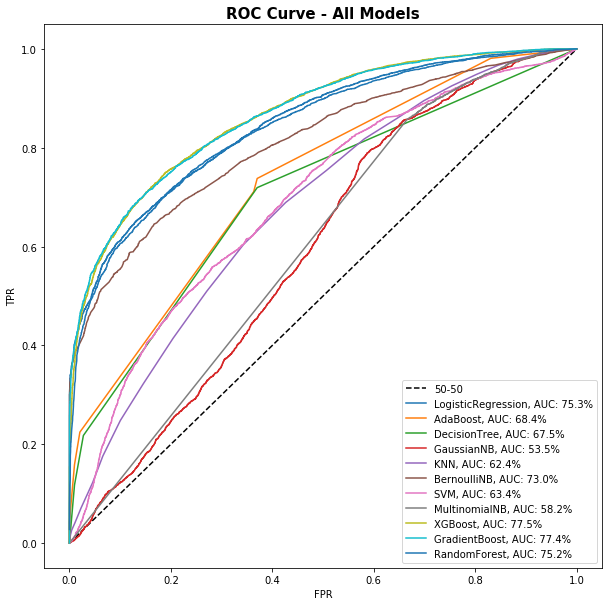

In [14]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(10, 10))

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')

# Plot Classifier ROC Curves
for key, value in roc.items():
    label = '{}, AUC: {}%'.format(key, round(100*value[1],1))
    ax.plot(roc[key][0][0], roc[key][0][1], label=label)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve - All Models',fontweight='bold',fontsize=15)
ax.legend(loc='best')
plt.savefig('../charts/roc_ds2_p1.png')

In [15]:
rd = pd.DataFrame(results_dict).T
rd = rd.apply(lambda x: round(100*x,1).astype(str) + "%")
rd = rd.sort_values(['auc'],ascending=[False])
rd

,accuracy,auc,f1_f,f1_s,precision_f,precision_s,recall_f,recall_s
XGBoost,77.5%,77.5%,75.8%,78.9%,73.6%,81.0%,78.0%,77.0%
GradientBoost,77.3%,77.4%,75.6%,78.8%,73.5%,80.8%,77.8%,77.0%
LogisticRegression,75.2%,75.3%,73.4%,76.8%,71.2%,78.9%,75.7%,74.8%
RandomForest,75.4%,75.2%,72.8%,77.4%,72.5%,77.8%,73.2%,77.1%
BernoulliNB,72.8%,73.0%,71.4%,74.0%,67.8%,77.7%,75.4%,70.6%
AdaBoost,68.9%,68.4%,64.7%,72.2%,66.4%,70.8%,63.0%,73.8%
DecisionTree,67.9%,67.5%,63.9%,71.1%,64.9%,70.3%,63.0%,71.9%
SVM,64.9%,63.4%,55.7%,70.9%,64.7%,65.0%,48.9%,78.0%
KNN,63.6%,62.4%,55.1%,69.5%,62.3%,64.4%,49.3%,75.4%
MultinomialNB,61.4%,58.2%,37.4%,72.1%,69.7%,59.7%,25.6%,90.9%
